# Queuing Theory for Software Engineers

- Capacity planning -> from DAU to throughput
- Predicting software performance with Little's Law
- Monitoring Queues
- Traffic shaping with Queues
- Answering to saturation examples: https://sre.google/sre-book/monitoring-distributed-systems/#xref_monitoring_golden-signals

## Exec Summary
Queues are a built-in mechanism everywhere in today's software. Not being familiar with the basics of queuing theory will prevent you from understanding the relations between latency & throughput, high-level capacity estimations, and workload optimization. Knowing the internals of queuing models is actually not that hard to grasp. In this article, I'll sum up the essence of what's required for a software engineer to be more effective in their field.

### Interesting Use-Cases Why????

### Queues Are Everywhere!
- Fork-join pool with work-stealing mechanism
- Java thread pools & unbounded queues
- Scylla DB?

# The Basics
Let's cover the basic concepts first before we discuss practical applications. What are the key metrics that are in play, when we're investigating a queue? We have the following relevant metrics when talking about queues in general.

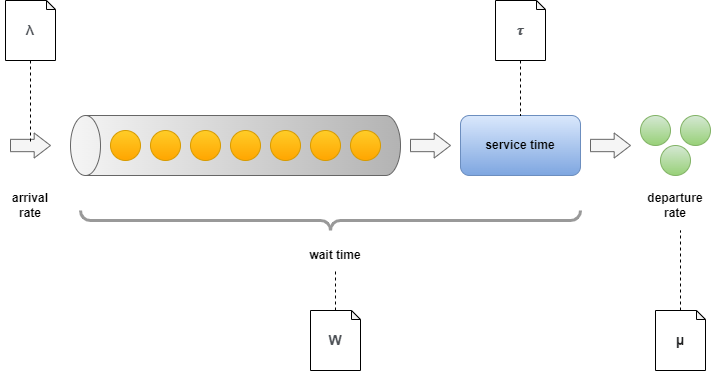

## Description of each term

- **Arrival rate:** ($\lambda$) The rate at which new work items arrive in the queue. 
- **Wait time:** ($W$) The total time spent by each work item in the system. Usually composed of two elements. Time spent in the queue (determined by preceding work items) and time spent with service. 
- **Servers:** ($c$) Referring to the level of parallelization. 
- **Service time:** ($\tau=1/\mu$) The time required to process a single work item. It's often translated to rate and called **departure rate**. 
- **Departure rate:** ($\mu$) The rate at which items are processed. 
- **Utilization:** ($\rho=\lambda/\mu$) Simply describes the ratio between arrival and departure rate. 

### Matching with practical naming and notation
In software engineering, we use slightly different terms when talking about performance. You can find a mapping between the notation used in queuing theory and their counterpart:

| Naming in model  | Naming in software systems   | Description |
| ---------------: | :--------------------------: | :---------- | 
| arrival rate/departure rate | throughput | Usually we don't distinguish between the two (although we should) and refer to them as throughput depending on the context. |
| wait time | latency | None of them distinguishes between wait time in the queue and waiting because being served. |
| servers | executors/processors | We mostly mean the number of CPUs/workers on that |
| service time | execution time/duration | Measured as the time required to do a single task. Often just mixed with latency. |
| utilization | utilization | Practically utilization is calculated with various methods. Often it means the ratio of unutilized CPU ticks and utilized ones over a given time window (e.g. 5 seconds). | 
| queue length | saturation | Most often they indicate the same thing: What's the extra workload the system has to cope with? The most popular usage of the term "saturation" comes from the [four golden signals](https://sre.google/sre-book/monitoring-distributed-systems/#xref_monitoring_golden-signals) mentioned in the Google SRE book.  |

### Simple use-cases
#### Sequential
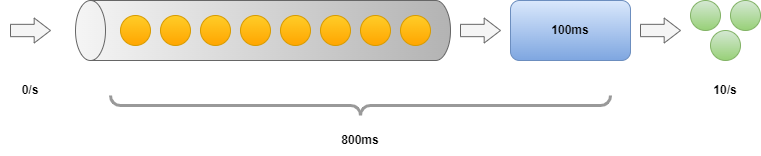

Now let's imagine having a simple queue like the one above. We have **8** items in the queue and **no new arrivals**, The execution duration is $100 ms$. What are the throughput and latency? We can produce a green marble in every $100 ms$, so that gives us $10/s$. The latency is a bit trickier to determine. The first item will have $100 ms$ latency. The last item requires all the previous ones to be processed, so its latency will be $8 * 100ms$. So the minimum latency is $100 ms$, the maximum is $800 ms$ and the mean is $450 ms$.

#### Parallel
Let's try to increase the number of executors. How the previous use-case is changing if we add another one?

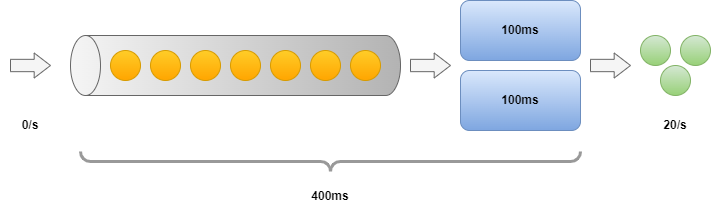

We can now produce 2 work items in every $100 ms$, so throughput is doubled to $20/s$. The first item requires $100 ms$ to process and the last one needs $400 ms$ (we can take 2 items on each $100 ms$ period). So the minimum latency is $100 ms$, the maximum is $400 ms$ and the mean is $250 ms$. 

An immediate important observation to make is that **the latency we're experiencing is determined by where we're sitting in the queue:** If the queue is empty or nearly empty - **scaling out has literally no effect on the latency**. As we'll see in the upcoming sections, having an increased amount of work items queued up has its own negative implications.

#### Pipelines
How do things change if we split the work differently than in the previous example? Let's assume we now have two queues attached to each other with two executors. The overall execution time will be the same as before. Will splitting the work have any effect on the latency/throughput? 

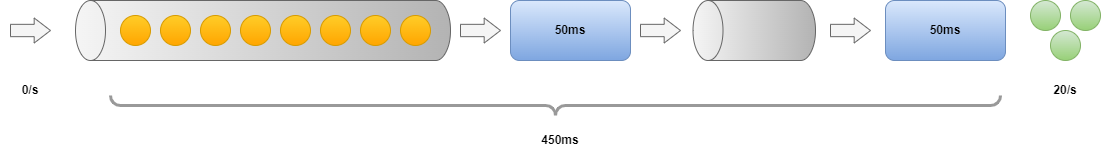

We can now produce 1 work item in every $50 ms$ doubling our throughput to $20/s$. The first item still requires $100 ms$ to pass through, but the last one only needs $450 ms$. Imagine that after the first $100 ms$ - when the first item is processed we're going to see a new green marble in each $50 ms$ until the queue gets empty. The minimum latency is $100 ms$, the maximum is $450 ms$ and the mean is $275 ms$.

This is where the power of **reactive libraries** comes from. Even though you might think you **write a sequential code** it's not executed as-is. Only your declaration of causation is sequential. You're declaring a pipeline of execution that splits your overall workload into smaller pieces and runs it in parallel. I can mention plenty of examples, like Kotlin coroutines, Java completable futures, the ReactiveX library, Akka, etc. **The observation above is still true: Latency is not changing if our queues have only a few elements**

⚠ TODO - P99, max latency indicating queue size increase ➡ Brendan Gregg

## Advanced Use-Cases
To be able to investigate more advanced use cases, we're shifting gears. I'm going to use this [simple modeling library](https://github.com/gitaroktato/queue-model-in-python) for the next couple of sections.

### Stable and unstable situations
What happens if the utilization is higher than 100%? In these cases, the arrival rate is larger than our overall throughput. How is it affecting our latency?


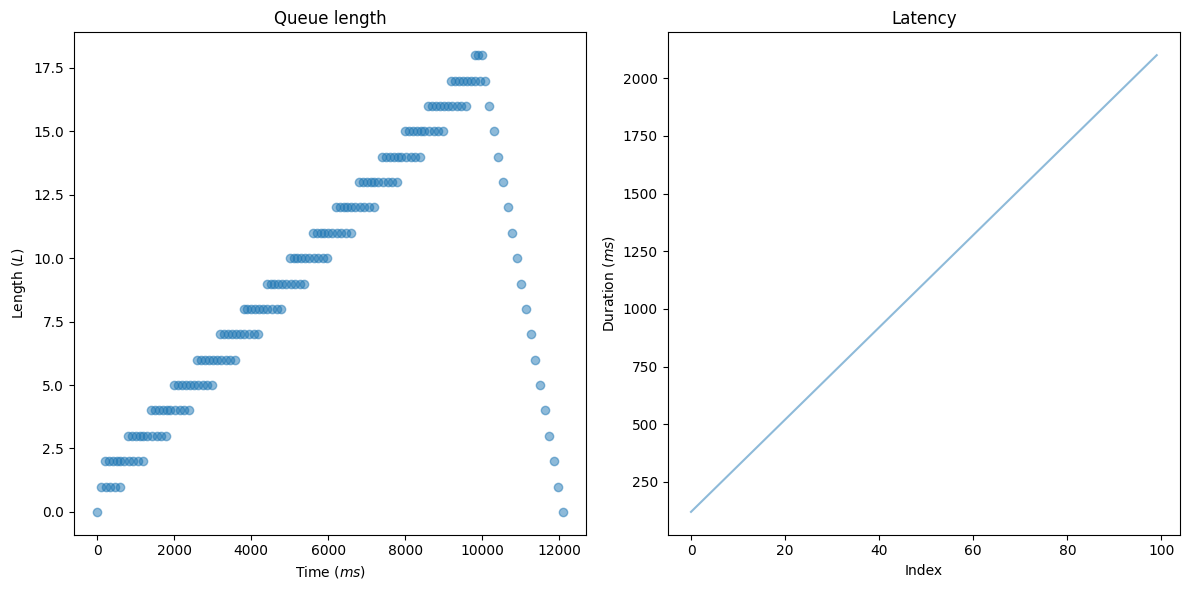

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from src.queue import Queue

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6) # (w, h)

SAMPLE_SIZE = 100
ARRIVAL_INTERVAL = 100
EXECUTION_INTERVAL = 120
EXECUTORS = 1

inter_arrival_time = np.full(shape=SAMPLE_SIZE, dtype=int, fill_value=ARRIVAL_INTERVAL)

queue = Queue(inter_arrival_time, np.full(shape=SAMPLE_SIZE, dtype=int, fill_value=EXECUTION_INTERVAL), executors=EXECUTORS)
queue.process()

fig, (queue_length, latency) = plt.subplots(1, 2)

queue_length.set_title("Queue length")
queue_length.set(xlabel=r'Time ($ms$)', ylabel=r'Length ($L$)')
queue_length.scatter(*zip(*queue.length_with_timestamps), alpha=0.5)

latency.set_title("Latency")
latency.set(xlabel='Index', ylabel=r'Duration ($ms$)')
latency.plot(queue.wait_times, alpha=0.5)

fig.tight_layout()
plt.show()


⚠ TODO - Scaling out over saturation, diminishing return after utilization < 1

# Capacity Planning: From DAU to Throughput


# References
## Wikipedia
- https://en.wikipedia.org/wiki/Queueing_theory
- https://en.wikipedia.org/wiki/Kendall%27s_notation
- https://en.wikipedia.org/wiki/Little%27s_law

## Various
- http://elearning.kocw.net/document/lec/2012/JoongAng/ChaHoonSang/7.pdf
- http://elearning.kocw.net/document/lec/2012/JoongAng/ChaHoonSang/8.pdf
- https://qmodels.readthedocs.io/en/latest/mm1.html
- https://www.youtube.com/watch?v=12XbrjiZ1FA
- https://github.com/miguelrizzog96/Queue_Simulation_Python/blob/master/server.ipynb
- https://notebook.community/xunilrj/sandbox/courses/IMTx-Queue-Theory/Week2_Lab_MM1
- https://github.com/eveneveno/MMC_queue
- https://github.com/miguelrizzog96/Queue_Simulation_Python
- [Site Reliable Engineering - Four golden signals](https://sre.google/sre-book/monitoring-distributed-systems/#xref_monitoring_golden-signals)

## Distributions
- https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html

## Numpy
- https://numpy.org/doc/stable/user/basics.creation.html
